In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import cv2
import itertools

from keras.models import Sequential, K, Model
from keras.layers import Conv2D
from keras import layers
from keras.layers import MaxPool2D, MaxPooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adadelta
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras

from sklearn.metrics import confusion_matrix, classification_report

from keras.applications import InceptionResNetV2, VGG16

Using TensorFlow backend.


In [0]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 17.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1tl7ZV1KkU4w7z5dHyK4xVNVEGAF7mpkW'})

In [0]:
download.GetContentFile('train_classification.zip')

In [0]:
!unzip train_classification.zip

Archive:  train_classification.zip
   creating: train_classification/
  inflating: train_classification/test.csv  
   creating: train_classification/train/
  inflating: train_classification/train.csv  
  inflating: train_classification/train/0.jpg  
  inflating: train_classification/train/1.jpg  
  inflating: train_classification/train/10.jpg  
  inflating: train_classification/train/100.jpg  
  inflating: train_classification/train/1000.jpg  
  inflating: train_classification/train/10000.jpg  
  inflating: train_classification/train/10001.jpg  
  inflating: train_classification/train/10002.jpg  
  inflating: train_classification/train/10003.jpg  
  inflating: train_classification/train/10004.jpg  
  inflating: train_classification/train/10005.jpg  
  inflating: train_classification/train/10006.jpg  
  inflating: train_classification/train/10007.jpg  
  inflating: train_classification/train/10008.jpg  
  inflating: train_classification/train/10009.jpg  
  inflating: train_classificatio

In [0]:
download = drive.CreateFile({'id': '1I4cMqb8LULIr-EwQFKfkBzNZI2VuUq_c'})

In [0]:
download.GetContentFile('sample_submission_CH2mq5Z.zip')

In [0]:
!unzip sample_submission_CH2mq5Z.zip

Archive:  sample_submission_CH2mq5Z.zip
  inflating: sample_submission_CH2mq5Z.csv  


In [0]:
!ls

adc.json     sample_submission_CH2mq5Z.csv  train_classification
sample_data  sample_submission_CH2mq5Z.zip  train_classification.zip


In [0]:
if not os.path.exists('/content/train_classification/train'):
        raise('No JPEGImages folder found')

***Displaying 10 Sample Images from the Dataset.***

In [0]:
samples = list(glob('/content/train_classification/train/*.jpg'))

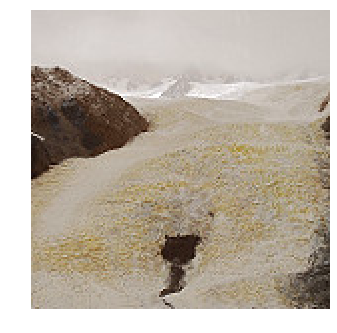

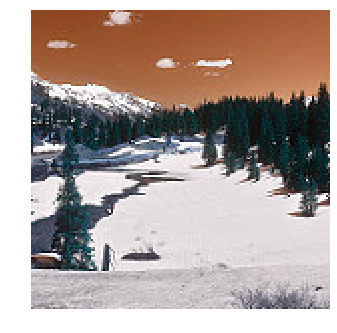

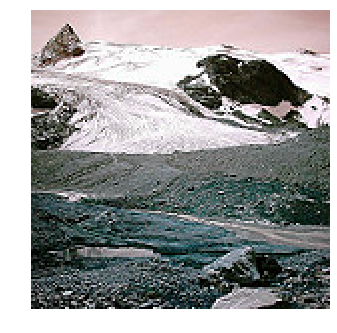

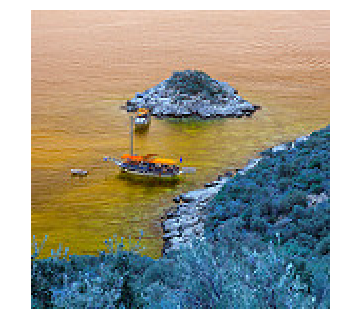

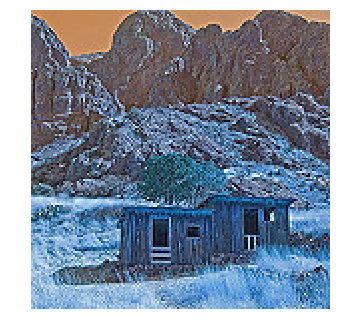

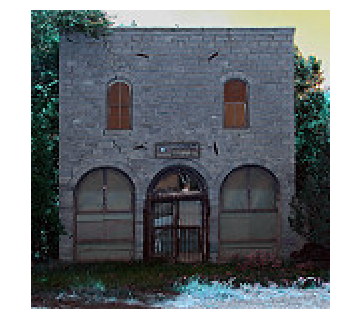

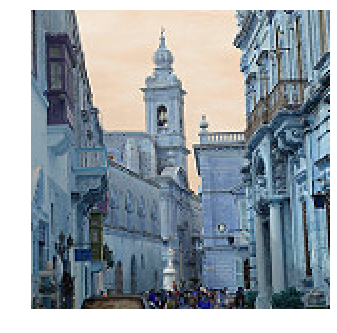

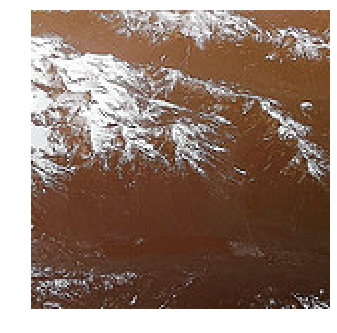

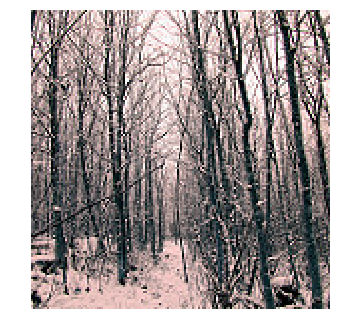

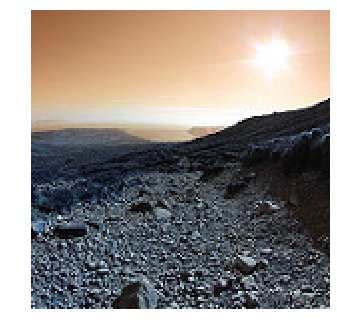

In [0]:
for sample in samples[:10]:
    img = cv2.imread(sample)
    #plt.figure(figsize=(4,4), dpi=100)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

***Train/Valid/Test Image Data Generator***

In [0]:
def append_ext(fn):
    return fn
traindf=pd.read_csv("train_classification/train.csv",dtype=str)
testdf=pd.read_csv("sample_submission_CH2mq5Z.csv",dtype=str)
traindf["image_name"]=traindf["image_name"].apply(append_ext)
testdf["image_name"]=testdf["image_name"].apply(append_ext)
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

In [0]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

In [0]:
train_generator=train_datagen.flow_from_dataframe(dataframe=traindf, directory="train_classification/train/", x_col="image_name", y_col="label", subset="training",
                                             batch_size=100, shuffle=False, class_mode="categorical", target_size=(150,150))

Found 17034 images belonging to 6 classes.


In [0]:
valid_generator=datagen.flow_from_dataframe(dataframe=traindf, directory="train_classification/train/", x_col="image_name", y_col="label", subset="validation",
                                             batch_size=100, shuffle=False, class_mode="categorical", target_size=(150,150))

Found 3406 images belonging to 6 classes.


In [0]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf, directory="train_classification/train/", x_col="image_name", y_col=None, batch_size=1,
                                                 shuffle=False, class_mode=None, target_size=(150,150))

Found 7301 images.


**Confusion Matrix User Defined Function**

In [0]:
#Confusion Matrix User Defined Function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='cividis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.axis('off')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Training model  User Defined Function**

In [0]:
# training model 

def fit(model, model_name, train_generator,validation_generator, batch_size, epochs, no_train_img, no_valid_img):
    
    '''
    training function to rain CNN model 
    
    Parameters:
    
    model - CNN model
    model_name - model name to save data 
    image_generator - generator to generate train/validation images
    batch_size - batch size
    epochs - number of epochs 
    no_train_img - number of training images
    no_valid_img - number of validation images
    '''
    
    
    
    #tensorboary
    print(model.summary())
    tbc = TensorBoard(log_dir='/output/{}'.format(model_name), histogram_freq=0, write_graph=True, write_images=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1, min_lr=0.00001, mode='auto', min_delta=0.0001, cooldown=0)
    earlystop = EarlyStopping(patience=10, restore_best_weights = True)
    callbacks = [earlystop, learning_rate_reduction, tbc]
    history =model.fit_generator(
        train_generator,
        steps_per_epoch=no_train_img // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=no_valid_img // batch_size,callbacks=callbacks  )
    
    #save
    model.save('{}.h5'.format(model_name)) 
    model.save_weights('{}_weights.h5'.format(model_name)) 
    
    #plot
    
    # Loss Curves
    plt.figure(figsize=[8,6]);
    plt.plot(history.history['loss'],'r',linewidth=3.0);
    plt.plot(history.history['val_loss'],'b',linewidth=3.0);
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Loss',fontsize=16);
    plt.title('Loss Curves {}'.format(model_name),fontsize=16);
   

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0);
    plt.plot(history.history['val_acc'],'b',linewidth=3.0);
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Accuracy',fontsize=16);
    plt.title('Accuracy Curves {}'.format(model_name),fontsize=16);
   

    print(history.history['val_acc'][-1])

**Prediction User-Defined Function**

In [0]:
def predict(model,model_name,image_generator,no_images,batch_size):
    
    '''
    Test function to test the CNN model 
    
    
    model - CNN model
    model_name - model name to save data 
    image_generator - image generator to generate test images
    batch_size = batch size 
    
    
    
    '''
    dict_characters = {0:'buildings',1:'forest',2:'glacier',3:'mountain',4:'sea',5:'street'}
    steps=no_images/batch_size
    predictions = model.predict_generator(image_generator, steps = steps)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = image_generator.classes
    class_labels = list(image_generator.class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)  
    cm =confusion_matrix(true_classes, predicted_classes)
    cm_plot_labels = list(image_generator.class_indices.keys()) 
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix {}'.format(model_name))

In [0]:
batch_size = 100
image_size = (150, 150)
input_shape = (150, 150,3)
epochs = 5

**Model 1**

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxP

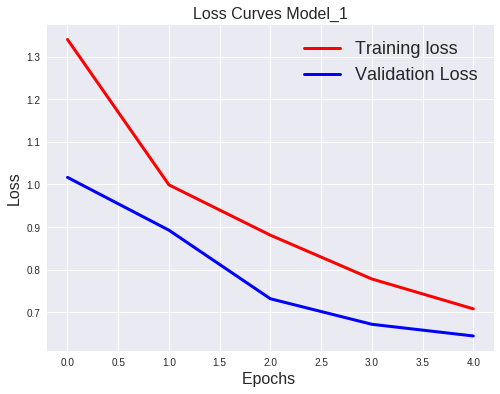

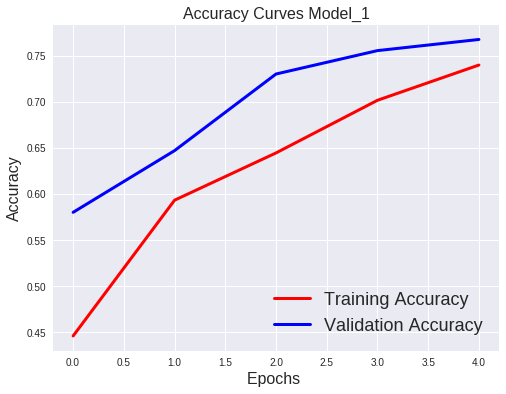

In [0]:
model_name = 'Model_1'
model_1 = Sequential()
# model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(150,150,3),padding='valid', strides=(1,1)))
# model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='valid', strides=(1,1)))
# model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
# model.add(Conv2D(32, (3, 3), activation='relu',padding='valid', strides=(1,1)))
# model.add(Conv2D(32, (3, 3), activation='relu',padding='valid', strides=(1,1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(64, (3, 3), activation='relu',input_shape=(150,150,3),padding='valid', strides=(1,1)))
model_1.add(Conv2D(64, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_1.add(Conv2D(128, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(256, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_1.add(Conv2D(256, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(512, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_1.add(Conv2D(512, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(6, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

#Calling the fit Function
fit(model_1, model_name, train_generator,valid_generator, batch_size, epochs, 17034, 3406)

In [0]:
list(train_generator.class_indices.keys()) 

['0', '1', '2', '3', '4', '5']

In [0]:
len(valid_generator.classes)

3406

In [0]:
#predict(model_1 ,'model_1',valid_generator,3406,100)

**Model 0**

In [0]:
K.clear_session()

model_name = 'Model_0'
model_0 = Sequential()
# model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(150,150,3),padding='valid', strides=(1,1)))
# model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',padding='valid', strides=(1,1)))
# model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
# model.add(Conv2D(32, (3, 3), activation='relu',padding='valid', strides=(1,1)))
# model.add(Conv2D(32, (3, 3), activation='relu',padding='valid', strides=(1,1)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(Conv2D(64, (3, 3), activation='relu',input_shape=(150,150,3),padding='valid', strides=(1,1)))
model_0.add(Conv2D(64, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_0.add(MaxPooling2D(pool_size=(2, 2)))

model_0.add(Conv2D(128, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_0.add(Conv2D(128, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_0.add(MaxPooling2D(pool_size=(2, 2)))

model_0.add(Conv2D(256, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_0.add(Conv2D(256, (3, 3), activation='relu',padding='valid', strides=(1,1)))
model_0.add(MaxPooling2D(pool_size=(2, 2)))

model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(Dropout(0.25))
model_0.add(Flatten())

model_0.add(Dense(1024, activation='relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(6, activation='softmax'))

model_0.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

#Calling the fit Function
fit(model_0, model_name, train_generator,valid_generator, batch_size, epochs, 17034, 3406)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 256)       295168    
__________

In [0]:
len(train_generator.classes)

In [0]:
#predict(model_0'model_0'train_generator,17034,100)

**Transfer Learning ResNet**

In [0]:
K.clear_session()

model_name = 'model_ResNet'

conv_base_res = InceptionResNetV2(weights='imagenet', include_top = False, input_shape = (150,150,3))
model_ResNet = Sequential()

model_ResNet.add(conv_base_res)
model_ResNet.add(layers.Flatten())

#batchnormalization
model_ResNet.add(BatchNormalization())
model_ResNet.add(layers.Dense(256, activation='relu'))

#dropout
model_ResNet.add(Dropout(0.5))
model_ResNet.add(layers.Dense(6, activation='softmax'))


model_ResNet.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

for layer in conv_base_res.layers[:-5]:
    layer.trainable = False

    
#Calling the fit Function
fit(model_ResNet, model_name, train_generator,valid_generator, batch_size, epochs, 17034, 3406)

In [0]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model_ResNet.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]



filenames=test_generator.filenames
results=pd.DataFrame({"image_name":filenames,
                      "label":predictions})
results.to_csv("results_26032019_res_2.csv",index=False)

In [0]:
from google.colab import files
files.download("results_26032019_res_2.csv")

**Model VGG16**

In [0]:
K.clear_session()

model_name = 'model_VGG16'

conv_base = VGG16(weights='imagenet', include_top=False, input_shape = (150,150,3))

model_v = Sequential()
model_v.add(conv_base)
model_v.add(layers.Flatten())
#batchnormalization

model_v.add(BatchNormalization())
model_v.add(layers.Dense(256, activation='relu'))
#dropout
model_v.add(Dropout(0.25))

model_v.add(BatchNormalization())
model_v.add(Dense(512, activation='relu'))
model_v.add(Dropout(0.5))

model_v.add(layers.Dense(6, activation='softmax'))

for layer in conv_base.layers[:-5]:
    layer.trainable = False
    
optimizer = keras.optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.9, epsilon=1e-08)
model_v.compile(loss='categorical_crossentropy',optimizer= optimizer ,metrics=['accuracy'])

#Calling the fit Function
fit(model_v, model_name, train_generator,valid_generator, batch_size, epochs, 17034, 3406)

In [0]:
#predict(model_v ,'model_1',valid_generator,3406,100)